In [5]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

# Unsupervised Learning

When we have a really high-dimensional dataset, we often want to lower the dimensionality of the problem.  For example, we might have a corpus of unlabeled documents and want to extract a set of topics $m$ for them.  Similarly, even a collection of 100 x 100 image would (naively) be a problem with 10,000 features.  We would like to learn lower dimensional versions of this.

For unsupervised learning, we will assume a set of feature vectors $x_j$.  These correspond to the rows of the features matrix $X_{ji}$. Unsupervised learning is a type of learning that occurs when you ony have features $X = \{X_{ji}\}$ but not labels $y_j$.  These algorithms revolve around clustering, i.e. assigning each row $X_{j \cdot}$ to a cluster $C_k$ such that the rows that share a cluster are more *similar* than ones from different clusters.  There are several ways to do this, some which require ground truth labeling and some which do not.  

## Metrics for Unsupervised Learning

The simplest form is **Inertia**, which is based on the 2nd moment of each cluster, (and if you are a physicist, this might be more appropriately called potential energy).  Let $\mu_k$ be the mean of all rows in cluster $k$, i.e. for all elements $X_{j \cdot} \in C_k$,
$$\mu_k = \frac{1}{|C_k|} \sum_{X_{j \cdot} \in C_k} X_{j \cdot}.$$
Then the inertia is defined as the sum of the inertia (or 2nd moment) of each cluster:
$$\sum_k \frac{1}{|C_k|} \sum_{X_{j \cdot} \in C_k} \| X_{j \cdot} - \mu_k\|^2_2\,.$$

Another metric is called the **Silhouette Coefficient**.  If $a_j$ is the mean distance between a point $X_{j \cdot}$ and the other points in the same cluster $C_k$ and $b_j$ is the mean is the distance between $X_{j \cdot}$ and the other points in the next nearest cluster $C_k'$, then the coefficient is given by
$$ \frac{b-a}{\max(a, b)}\,. $$

Assuming you have ground truth values $\tilde C_k$ and predicted classification labels $C_k$, it is easy to calculate their **Mutual Information** and use those as a technique.  Mutual information has deep ties to information theory [see the Wikipedia article](http://en.wikipedia.org/wiki/Mutual_Information).  If $N$ is the total number of samples (number of rows of $X$), we can define the probabilities
$$ P_k = \frac{|C_k|}{N} \qquad \tilde P_k = \frac{|\tilde C_k|}{N} \qquad P_{k,l} = \frac{|C_k \cap \tilde C_l|}{N} $$
and then the mutual information is defined as
$$ \sum_{k, l} P_{k,l} \log\left(\frac{P_{k,l}}{ P_k \tilde P_l }\right)\,. $$

There are a plethora of metrics.  For more information, checkout the [Scikit Learn page on Clustering Metrics](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation).

**Questions**:
1. How do the values of each of the measures scale with the scaling of the feature space (e.g. $X \mapsto 2X$)?
1. For a fixed number of points, how do each of the measures scale with the number of clusters?
1. In the below example, write the inertia metric by hand and use an interface like `metrics.silhouette_score`

In [1]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import datasets

# Fit KMeans onto the Iris dataset
dataset = datasets.load_iris()
X = dataset.data
k_means = KMeans().fit(X)
y = k_means.predict(X)

# Compute Silhoutte score on clusters:
print "Silhouette Score", metrics.silhouette_score(X, y, metric='euclidean')

# Entropy
labels_true = [1, 1, 0, 1, 2, 2, 1, 2, 0]
labels_pred = [1, 0, 1, 1, 2, 1, 1, 2, 2]

print "Adjusted Mutual Information ", metrics.adjusted_mutual_info_score(labels_true, labels_pred)
print "Mutual Information ", metrics.mutual_info_score(labels_true, labels_pred)

Silhouette Score 0.355308573663
Adjusted Mutual Information  0.0311544800892
Mutual Information  0.320757480375


# Clustering

## $K$-Means
The specification of $K$-means is simple: assign a collection of clusters $C_k$ that minimize

$$ \mbox{argmin}_C \sum_{k=1}^K \sum_{X_j \in C_k} \| X_{j\cdot} - \mu_k \|_2^2 $$

where $\mu_k$ is the center of the points in $C_k$.  The algorithm to implement this is simple:

Initialize $\mu_k$ (with possibly random values).  Then iterate between
1. Assign $X_{j\cdot}$ to the cluster $C_k$ that minimizes $\|X_{j\cdot} - \mu_k\|_2^2$.
1. Recompute $\mu_k$ by averaging over all the points $X_{j\cdot}$ in the cluster $C_k$.

Notice that both iterative steps lower the objective (the algorithm is greedy) and there are only a finite number of possible partisions of the points $X_{j\cdot}$ so the algorithm is gauranteed to converge.  The converged solution may not be globally optimal.

**Question:** What is a shortcoming of $K$-Means under scaling?

## Gaussian Mixture Models
We can generalize the notion of $K$-Means in two ways:
1. Instead of requiring that each $X_{j\cdot}$ strictly belong to a single $C_k$, we say it belongs to $C_k$ with a probability
1. Insteading of just having $\mu_k$ as a degree of freedom, we have the pair $(\mu_k, \Sigma_k)$

Then each $X_{j\cdot}$ is of type $k$ with probability proportional to
$$ p_k \exp \left( \frac{1}{2} (X_{j\cdot} - \mu_k) \cdot \Sigma_k^{-1}(X_{j\cdot} - \mu_k) \right) $$
where $p_k > 0$ is a proportionality constant.
While this is not strictly a clustering algorithm, it can be turned into one but choosing the probability cluster with the highest probability.

**Question**:
1. For KMeans, what happens if the features have very different scales?
1. Does this problem exist for Gaussian Mixture Models?

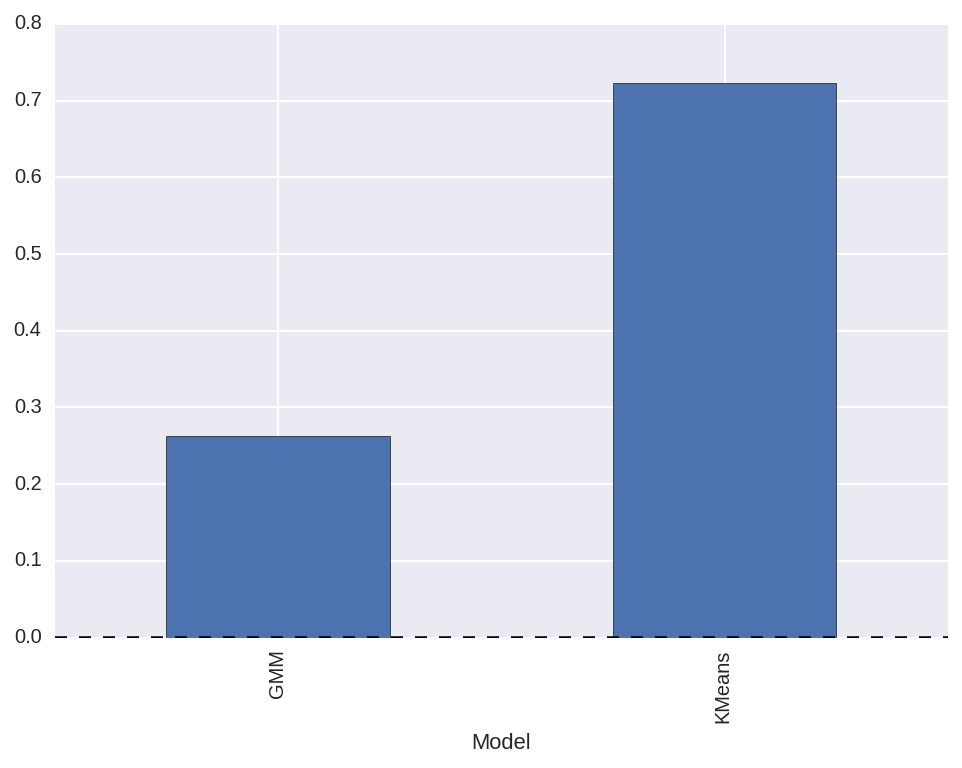

In [10]:
from sklearn import cluster, mixture, datasets
import pandas as pd

# load Boston dataset
diabetes = datasets.load_boston()

columns = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSAT"]
X = pd.DataFrame(diabetes.data, columns=columns)
y = pd.Series(diabetes.target)

gmm_clf = mixture.GMM(n_components=3, random_state=42).fit(X)
kmeans_clf = cluster.KMeans(n_clusters=3, random_state=42).fit(X)

# Compute the Silhouette
pd.DataFrame([
    ("GMM",  metrics.silhouette_score(X, gmm_clf.predict(X), metric='euclidean')) ,
    ("KMeans",  metrics.silhouette_score(X, kmeans_clf.labels_, metric='euclidean'))
], columns=["Model", "Silhouette"]).plot(x="Model", y="Silhouette", kind="bar")


**Exercise**:
1. Normalize KMeans to improve performance use the scale function
1. Test the inertia criterion you added earlier and graph it in the above plots

# Random Projections

One really simple method of reducing the data is to do it at random.  That is, instead of using $X$, we use $X' = X P$ where $P$ is a $p \times m$ matrix of randomly generated values.  This is effectively projecting the data onto the rows of $P$.  When $p \gg m$, the rows of $P$ are highly likely to be orthogonal.  While they don't give a very faithful representation of the original data (PCA or NMF would do better), for classificaiton and regression purposes, they often give enough signal for the job.  They are much fast to compute and are good for prototyping.  They can often be a good standby as part of a learning pipeline which can be upgraded to a more principled technique as necessary.

You can read more about Random Projections in the [Scikit Documentation](http://scikit-learn.org/stable/modules/random_projection.html).  We give a simple example that implements them below.

**Exercise:** This projects $X$ onto a random subspace of dimension $m$ while PCA or NMF can project us onto an "optimal" subspace of dimension $m$.  When and why would you use random projections?

In [3]:
import numpy as np
from sklearn import random_projection

X = np.random.rand(100, 10000)
transformer = random_projection.GaussianRandomProjection(n_components=30)
X_new = transformer.fit_transform(X)
X_new.shape

(100, 30)

# Matrix Factorization

Recall that for $X$ an $n \times p$ matrix, we have the [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) with

$$ X = U \Sigma V^T $$

where $U$ is a unitary $n \times n$ matrix, $\Sigma$ is a diagonal $n \times p$ matrix, and $V$ is a unitary $p \times p$ matrix.  We can imagine that 

**Exercise**: What happens if $X$ is a square and symmetric?  (The result is called spectral theorem, which roughly says $U = V^T$).  In particular, how do the SVD of $X^T X$ or $X X^T$ relate to that of $X$ (you can work out the algebra ...)

## Prinicpal Components Analysis (PCA)

We think of the SVD as decomposing $X$ into orthogonal (i.e. independent) components with strengths given by the diagonal of $\Sigma$,

$$ \Sigma = \left[ \begin{array}{ccc} 
\sigma_1 & \\
& \sigma_2 & \\
&& \ddots & \\
&&&
\end{array} \right]$$

By convetion, we assume $|\sigma_1| \ge |\sigma_2| \ge \cdots$.  One interpretation of this is that $\sigma_1$ corresponds to the largest component of variation, $\sigma_2$ corresponds to the second largest etc ... We often think of the smaller components as being just noise and the larger components as being being signal.  Therefore, it makes sense to truncate $\Sigma$ to its largest $m$ copmonents and just keep those.  In Scikit, this algorithm `sklearn.decomposition.PCA` returns $U \Sigma P_m$ where $P_m$ is the projection operator onto the first $m$ dimensions.  (In reality, it performs a stochastic SVD, which should be faster than the exact SVD).

There's a really great brief article on PCA on [Stats StackExchange](https://stats.stackexchange.com/questions/10251/how-to-find-principal-components-without-matrix-algebra).

**Exercise**:
1. What is the answer to $\max_{u : \| u \| = 1} u^T X^T X u $ and how does it relate to SVD.
1. **Gotcha**: Why is it important to subtact the mean (mean centering) before performing PCA?

## Non-negative Matrix Factorization (NMF)

We can phrase an $m$ dimensional PCA as
$$ \min_{U, \Sigma_m, V} \| X - U \Sigma_m V \|_2 $$
where $U$ is a unitary $n \times n$ matrix, $\Sigma_m$ is a diagonal $n \times p$ matrix with rank $m$, and $V$ is a unitary $p \times p$ matrix.  If we absorbe the $\Sigma_m$ into $U$ and $V$ as $W$ and $H$, we could rewrite this as 
$$ \min_{W, H} \| X - W H \|_2 $$
where $W$ is a $n \times m$ matrix and $H$ is a $m \times p$ matrix.  If $X$ has only non-negative values, we might want $W$ and $H$ to have non-negative values as well.  Hence, Non-negative Matrix Factorization is just
$$ \min_{W \ge 0, H \ge 0} \| X - W H \|_2 $$
when $X \ge 0$ (here, we use $X \ge 0$ to mean that each element of $X$ has non-negative values).  While PCA gives you a more accurate low-dimensional representation, NMF can give a more interpretable results since the values are non-negative.

In scikit, the matrix $H$ is called the `components_` while $W$ is the value returned from `.transform`.

Below, we are analyzing images of faces.  Each row is a greyscale 64 x 64 dimensional image so the feature space is 4096 dimensional!

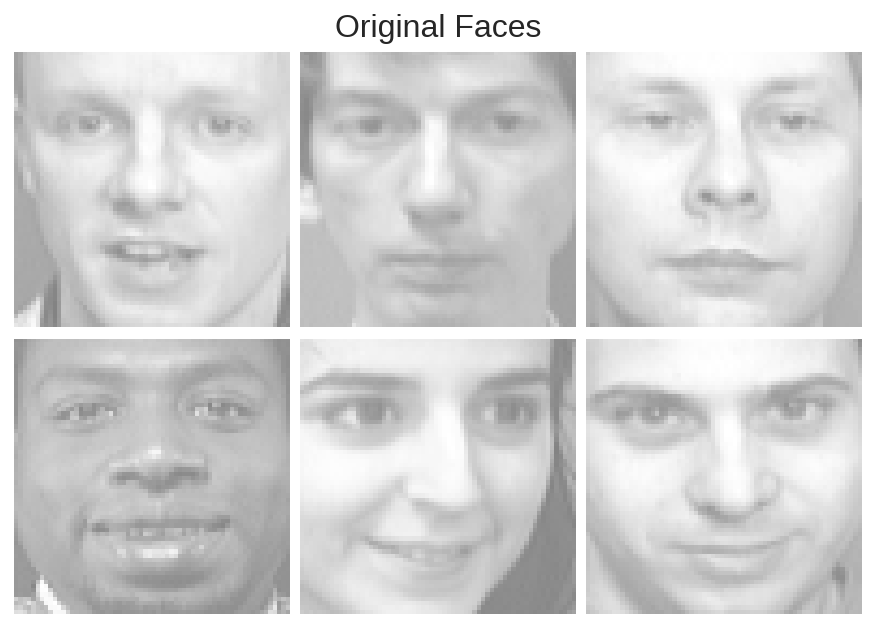

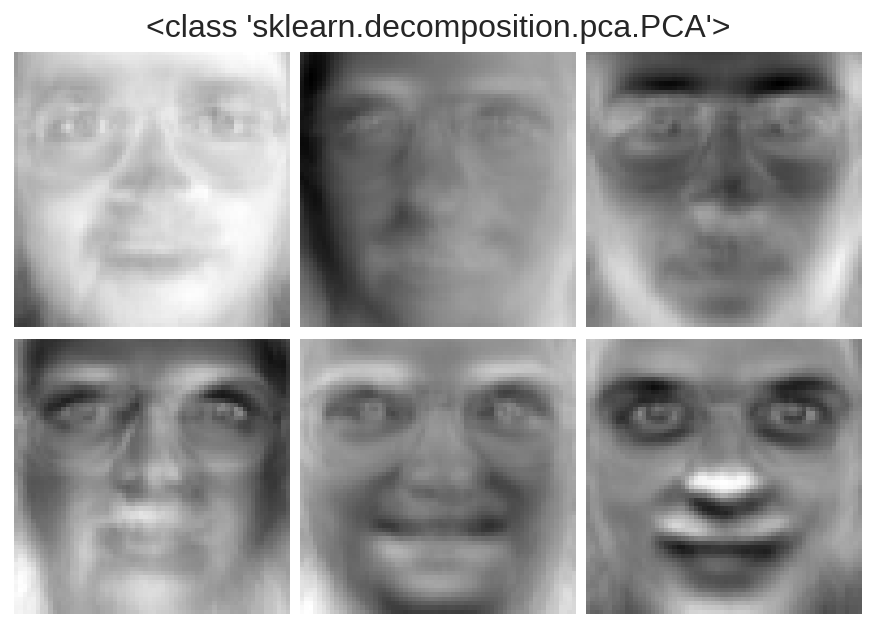

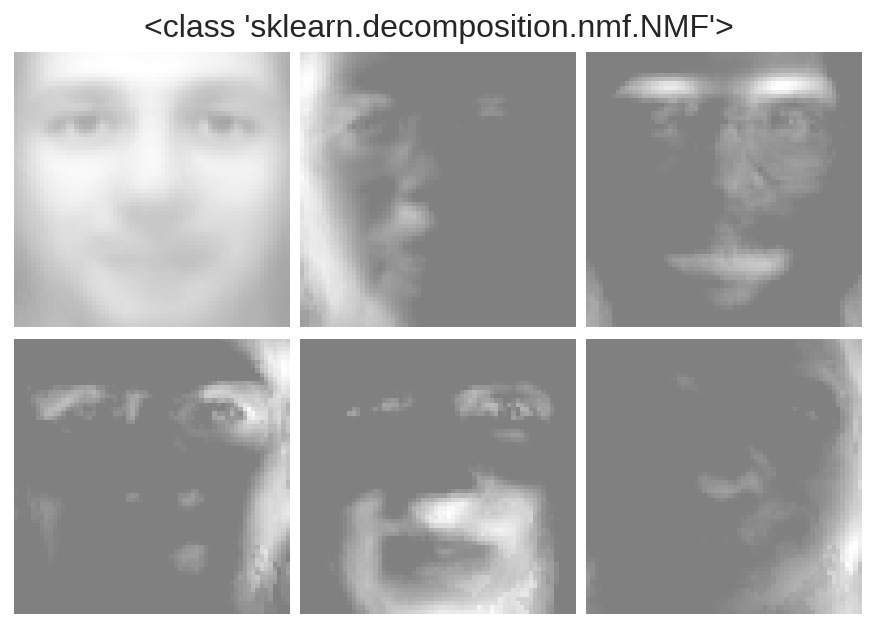

In [6]:
# Eigenfaces using NMF and PCA

from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition
from matplotlib import pyplot as plt

# Fetch data of faces, each face is a greyscale 64 x 64 dimensional image
# making this a 4096 dimensional feature space
dataset = fetch_olivetti_faces(shuffle=True, random_state=42)
X = dataset.data

n_col = 3
n_row = 2
n_components = n_col * n_row
image_shape = (64, 64)

def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                  interpolation='nearest',
                  vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

estimators = [
    decomposition.PCA(n_components=n_components, whiten=True),
    decomposition.NMF(n_components=n_components, init='nndsvda', beta=5.0,
                       tol=5e-3, sparseness='components'),
]

plot_gallery("Original Faces", X[:6,:], n_row=n_row, n_col=n_col)
for estimator in estimators:
    estimator.fit(X)
    plot_gallery(str(estimator.__class__), estimator.components_, n_row=n_row, n_col=n_col)

**Exercise**:
1. `np.dot(pca.transform(X), pca.components_)` will project the transformed (low-dimensional) compressed features `pca.transform(X)` back to the original 4096-dimensional space.  Use to this visualize the reconstructed "compressed" images for different faces.  Do the same for `nmf`.  There's a lot of faces, you probably only want to visualize them for a fraction of the faces.
1. Vary `n_copmonents` and see how the `pca` low-dimensional reconstucted varies with different values of `n_components`.

In [7]:
# Topic modelling using NMF
# Adapted from http://scikit-learn.org/stable/auto_examples/applications/topics_extraction_with_nmf.html

from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups

n_samples = 20000
n_features = 1000
n_topics = 10
n_top_words = 20

# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

t0 = time()
print("Loading dataset and extracting TF-IDF features...")
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                             stop_words='english')
tfidf = vectorizer.fit_transform(dataset.data[:n_samples])
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
nmf = NMF(n_components=n_topics, random_state=1).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Loading dataset and extracting TF-IDF features...
done in 22.940s.
Fitting the NMF model with n_samples=20000 and n_features=1000...
done in 37.894s.
Topic #0:
game team year games season players play hockey win league player teams nhl runs best better hit good did time
()
Topic #1:
god jesus bible believe christ faith christian christians church say sin life does lord truth hell man love christianity belief
()
Topic #2:
windows file use files dos window program using problem running card version screen run pc graphics memory drivers software application
()
Topic #3:
just don like think know ve good really ll got sure want say thing things time going doesn little way
()
Topic #4:
key chip encryption clipper keys use government escrow public algorithm phone data bit nsa security secure number chips law des
()
Topic #5:
drive scsi hard disk drives controller ide card floppy bus mac cd apple internal cable computer mb ram rom tape
()
Topic #6:
thanks does know advance mail hi anybody look

/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/nmf.py:533: UserWarning: Iteration limit reached during fit
  warnings.warn("Iteration limit reached during fit")


# Resricted Boltzman Machine

A restricted Boltzman Machine is a type of neural-network that's used for machine learning.  It's given in the diagram of a bi-partite graph below:

![RBM Graph from Scikit website](../images/rbm_graph.png)

The $p$ nodes labeled $v$ are the *visible* nodes and represent data (a row of $X$ in our notation).  The $m$ nodes labeled $h$ represent hidden states and the $m \times p$ $W$ edges represent a matrix that gives the interactions between the visible and hidden nodes.  (NB: while $W$ is the standard notation for this area, it plays the analogous role to $H$ in the PCA, NMF notation above).  Why does it have a funny name?
1.   This machine is *Restricted* because the connections between states are confined to a bipartite graph (there are no connections between $h$'s or $v$'s.  This means all its relationships can be represented by a matrix $W$.  This also implies conditional indpendence amongst the $h$'s and the $v$'s,

    $$ h_i \perp h_j | v \qquad v_i \perp v_j | h $$

2.  This machine is *Boltzman* because for a given $v$ and $h$, we assign it an energy

    $$ E(v, h) = v^T W h + b^T v + c^T h $$
    
    where in addition to $W$, we have the visible and hidden intercepts, $b$ and $c$.  The probability of a state is given by
    
    $$ P(v, h) = \frac{e^{-E(v,h)}}{Z} $$
    
    where $Z$ is called a *partition function* in physics and is just the necessary coefficient to make $P$ a probability distribution.  We then train the RBM to maximize the probability
    
    $$ \max_{W, b, c} P(v, h) = \sum_h P(v, h) $$
    
    This is ofen done using [contrastive divergence](http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf).  It is then easy to compute
    
    $$ P(h | v) $$
    
    to obtain the hidden nodes from the visible nodes.

In Scikit, `sklearn.neural_network.BernoulliRBM` maxizes log-likelihood using Stochastic Maximum Likelihood (see the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html)).  This is an iterative stochastic algorithm that takes a number of parameters,

<table>
<tr>
<th>Parameter</th>
<th>Meaning</th>
</tr>

<tr>
<td>`learning_rate`</td>
<td>Learning Rate</td>
</tr>

<tr>
<td>`n_iter`</td>
<td>Iterations to run</td>
</tr>

<tr>
<td>`n_components`</td>
<td>Number of hidden states</td>
</tr>
</table>
   
   Once the model is trained, the outputs map to the mathematical notation we have expressed above members on the return object

<table>
<tr>
<th>Math</th>
<th>Scikit</th>
</tr>

<tr>
<td>$W$</td>
<td>`.components_`</td>
</tr>

<tr>
<td>$b$</td>
<td>`.intercept_visible_`</td>
</tr>

<tr>
<td>$c$</td>
<td>`.intercept_hidden_`</td>
</tr>
</table>

**Exercise**: Train a RBM on the faces dataset as we did for PCA and NMF.  The hidden states are like the eigenfaces.  Draw them out and take a look at what they look like.

# Spoilers

# Answers

### Metrics for Unsupervised Learning

1. As you scale in feature space, inertia scales as the square, Silhouette is invariant, and Mutual Information does not scale (why?).
1. For a fixed number of points, increasing the number of clusters tends to decrease Inertia.  The effect on Silhouette is less easily determined.  Mutual information will tend to decrease as well.
1. Straightfoward.

### Clustering

1. For KMeans, if the features have very different scales you should normalize the data first.
1. This problem does not exist for Gaussian Mixture Models because of $\Sigma$.

### Random Projections

1. While the subspace chosen by PCA or NMF might be "optimal", these algorithms are much more computationally expensive.  You would use random projects for prototyping (where speed matters) or because you have much more "signal" than you need to do your classification / regression job and some random subset of the signal will do.

### Matrix Factorization
1. $\max_{u : \| u \| = 1} u^T X^T X u = \sigma^2_1$ and the answer should be obvious at this point.  This should give some intuition for why $\sigma_1$ corresponds to the largest component of variation.
1. It important to subtact the mean (mean centering) before performing PCA.  Otherwise the first component might just be the mean of the data.

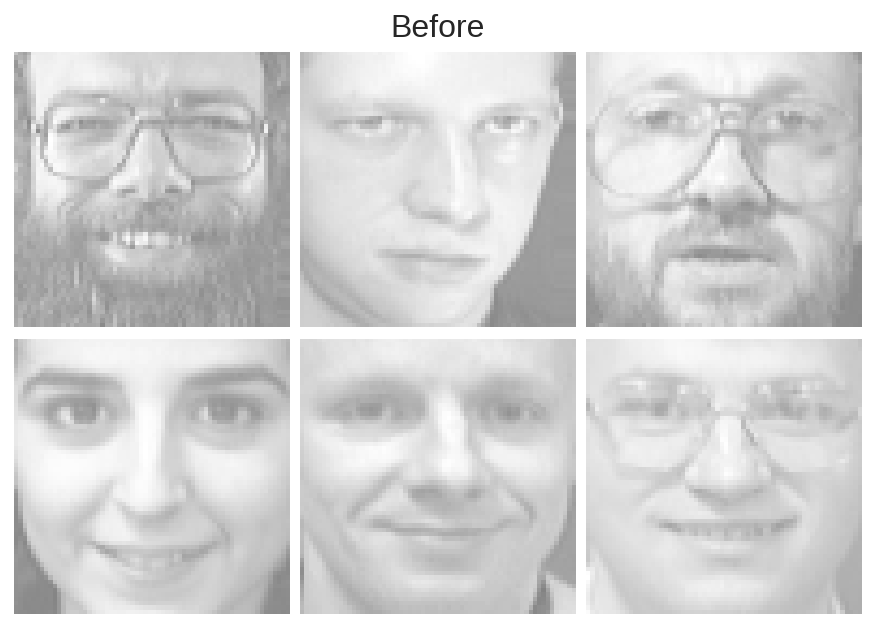

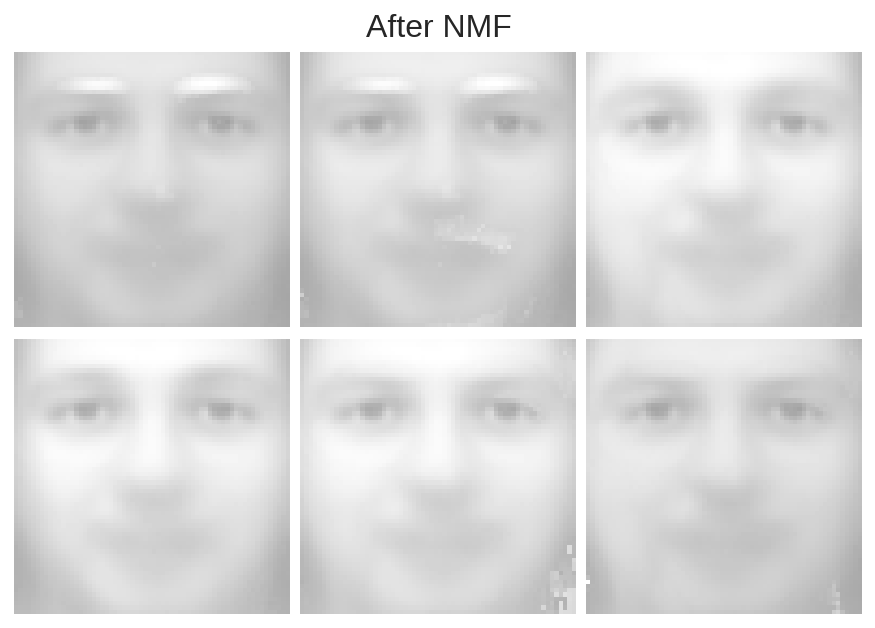

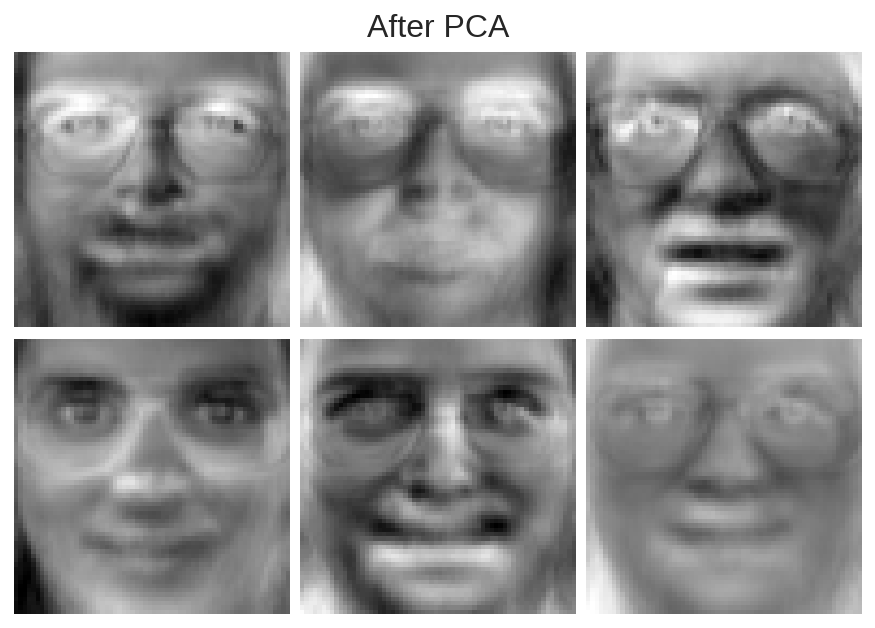

In [8]:
# Reconstructed faces at n_components = 10

import random

n_col = 3
n_row = 2
n_samples = n_col * n_row

random.seed(42)
X_sample = random.sample(X, n_samples)

n_components = 10

pca = decomposition.PCA(n_components=n_components, whiten=True).fit(X)
nmf = decomposition.NMF(n_components=n_components, init='nndsvda', beta=5.0,
                       tol=5e-3, sparseness='components').fit(X)

def projector(M):
    U, _, V = np.linalg.svd(M)
    S = np.ones([U.shape[0], V.shape[1]])
    return np.array(np.matrix(U) * np.matrix(S) * np.matrix(V))

proj = projector(nmf.components_)

plot_gallery("Before", X_sample, n_row=n_row, n_col=n_col)
plot_gallery("After NMF", np.dot(nmf.transform(X_sample), nmf.components_), n_row=n_row, n_col=n_col)
plot_gallery("After PCA", np.dot(pca.transform(X_sample), pca.components_), n_row=n_row, n_col=n_col)


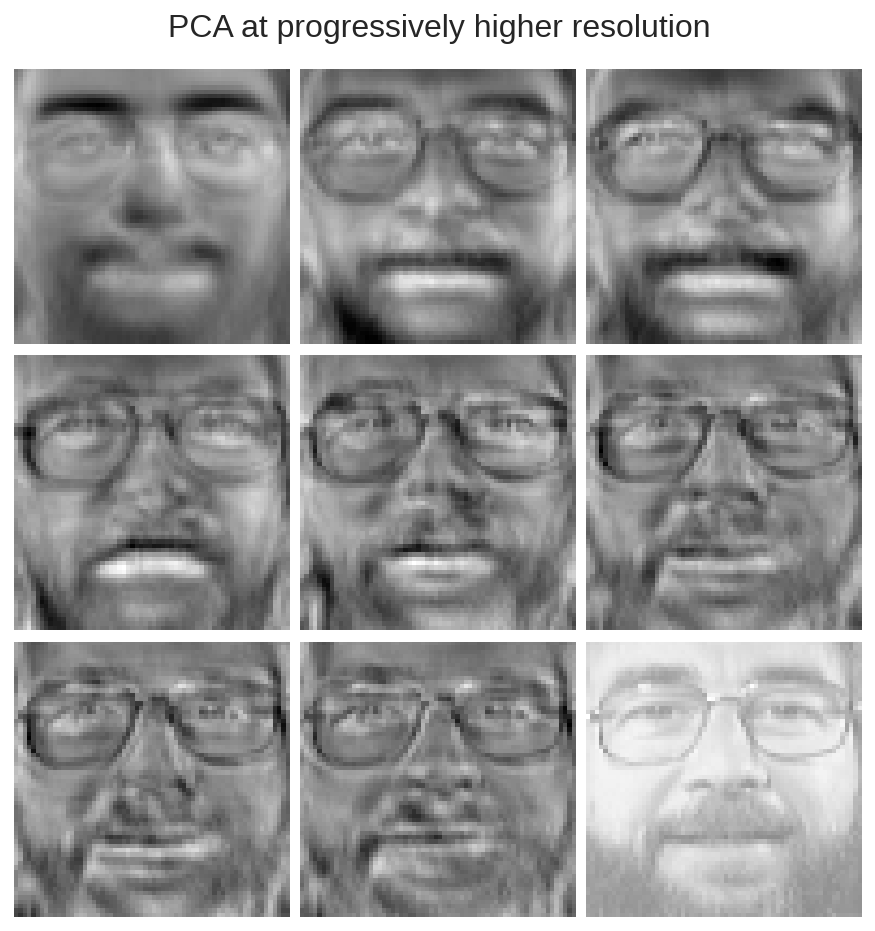

In [9]:
# A reconstructed face compressed to various numbers of components

import random

n_col = 3
n_row = 3
n_show = n_col * n_row
components_delta = 10

random.seed(42)
X_sample = random.sample(X, n_samples)

n_components = 10

pcas = [decomposition.PCA(n_components=n_components, whiten=True).fit(X) 
            for n_components in xrange(components_delta, n_show * components_delta, components_delta)]
plot_data = [np.dot(pca.transform(X[23:24]), pca.components_) for pca in pcas] + [X[23]]
plot_gallery("PCA at progressively higher resolution", plot_data, n_col=n_col, n_row=n_row)


*Copyright &copy; 2015 The Data Incubator.  All rights reserved.*